# 02 - Data from the Web

## Deadline
Wednesday October 25, 2017 at 11:59PM

## Important Notes
* Make sure you push on GitHub your Notebook with all the cells already evaluated (i.e., you don't want your colleagues to generate unnecessary Web traffic during the peer review)
* Don't forget to add a textual description of your thought process, the assumptions you made, and the solution you plan to implement!
* Please write all your comments in English, and use meaningful variable names in your code.

## Background
In this homework we will extract interesting information from www.topuniversities.com and www.timeshighereducation.com, two platforms that maintain a global ranking of worldwide universities. This ranking is not offered as a downloadable dataset, so you will have to find a way to scrape the information we need!
You are not allowed to download manually the entire ranking -- rather you have to understand how the server loads it in your browser. For this task, Postman with the Interceptor extension can help you greatly. We recommend that you watch this [brief tutorial](https://www.youtube.com/watch?v=jBjXVrS8nXs&list=PLM-7VG-sgbtD8qBnGeQM5nvlpqB_ktaLZ&autoplay=1) to understand quickly how to use it.

## Assignment
1. Obtain the 200 top-ranking universities in www.topuniversities.com ([ranking 2018](https://www.topuniversities.com/university-rankings/world-university-rankings/2018)). In particular, extract the following fields for each university: name, rank, country and region, number of faculty members (international and total) and number of students (international and total). Some information is not available in the main list and you have to find them in the [details page](https://www.topuniversities.com/universities/ecole-polytechnique-fédérale-de-lausanne-epfl).
Store the resulting dataset in a pandas DataFrame and answer the following questions:
- Which are the best universities in term of: (a) ratio between faculty members and students, (b) ratio of international students?
- Answer the previous question aggregating the data by (c) country and (d) region.

Plot your data using bar charts and describe briefly what you observed.

2. Obtain the 200 top-ranking universities in www.timeshighereducation.com ([ranking 2018](http://timeshighereducation.com/world-university-rankings/2018/world-ranking)). Repeat the analysis of the previous point and discuss briefly what you observed.

3. Merge the two DataFrames created in questions 1 and 2 using university names. Match universities' names as well as you can, and explain your strategy. Keep track of the original position in both rankings.

4. Find useful insights in the data by performing an exploratory analysis. Can you find a strong correlation between any pair of variables in the dataset you just created? Example: when a university is strong in its international dimension, can you observe a consistency both for students and faculty members?

5. Can you find the best university taking in consideration both rankings? Explain your approach.

Hints:
- Keep your Notebook clean and don't print the verbose output of the requests if this does not add useful information for the reader.
- In case of tie, use the order defined in the webpage.

In [1]:
# Import libraries
# Common
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# Web scraping
import requests
from bs4 import BeautifulSoup
import json

# Merging names. Installation: pip install fuzzywuzzy and pip install fuzzywuzzy[speedup]
from fuzzywuzzy import fuzz
from fuzzywuzzy import process
from IPython.core import display as ICD

# 1) QS RANKING
First we get the following data of each university represented in the ranking with a single request:
* name
* rank
* country
* region
* url



Then we convert this information converting it into a DataFrame.

In [2]:
# Make a request
url_main = 'https://www.topuniversities.com'  # Found with postman
r = requests.get(url_main + '/sites/default/files/qs-rankings-data/357051.txt')
print('Response status code: {0}\n'.format(r.status_code))
page_body = r.text

# Serialize the json data with json library
rank_json = json.loads(page_body)

# Converting the data into a pd.DataFrame
rank_df = pd.DataFrame()
rank_df = rank_df.from_dict(rank_json['data']).head(200)
rank_df.drop(['logo', 'stars', 'nid','cc', 'score'], axis=1, inplace=True)
rank_df.set_index('core_id', inplace=True)
rank_df = rank_df[['title', 'rank_display', 'country', 'region', 'url']]
rank_df.head(2)

Response status code: 200



,title,rank_display,country,region,url
core_id,,,,,
410,Massachusetts Institute of Technology (MIT),1,United States,North America,/universities/massachusetts-institute-technolo...
573,Stanford University,2,United States,North America,/universities/stanford-university


### Helper functions

Here we define two functions that we'll use _for every university_ to retrieve more specific data.
Both functions take as argument the dataframe above, and return a second dataframe with the info requested. Such dataframes will be concatenated to have the full information avaiable in a single dataframe.

`my_find()` retrieves the following information:
* total faculty members 
* international faculty members 
* total students 
* total international students 
 
`find_Score_Citations()` retrieves

* score citations


since in the future we'll use _score citations_ to calculate the best university according to both QS and THE ranking.

In [3]:
def my_find(html_attributes, new_df_column_name, rank_df):
    _tag = html_attributes['tag']
    _class = html_attributes['class']
    # _list is a temporary list that will store the values found and then be converted in the df to be returned.
    _list = []
    for url in rank_df.url:
        # for every url contained in rank_df['url'], perform the corresponding request:
        uni_url = requests.get(url_main + url)
        uni_body = uni_url.text
        soup = BeautifulSoup(uni_body, 'html.parser')
        soup1 = soup.find(_tag, class_=_class)
        
        # if such tag has been found, look then for <tag=_tag, class='number> where the value 
        # we're interested in is stored! otherwise append -99
        if soup1:
            soup2 = soup1.find(_tag, class_='number') 
            if soup2:
                _list.append({new_df_column_name: soup2.text})
            else:
                _list.append({new_df_column_name: -99})
        else:
            _list.append({new_df_column_name: -99})
    # convert _list to dataframe and return it
    return pd.DataFrame.from_dict(_list).replace({r'\n': ''}, regex=True).replace({r',': ''}, regex=True).apply(pd.to_numeric).astype(int)

def find_Score_Citations(rank_df):
    # function designed just to retrieve the Score citation score, since it follows a different html structure.
    # _list is a temporary list that will store the values found and then be converted in the df to be returned.
    _list = []
    for url in rank_df.url:
        # for every url contained in rank_df['url'], perform the corresponding request:
        uni_url = requests.get(url_main + url)
        uni_body = uni_url.text
        soup = BeautifulSoup(uni_body, 'html.parser')
        soup1 = soup.find('ul', class_='score')                      # main tag identifying the collection of all the scores
        if soup1:
            soup2 = soup1.findAll('li', class_='barg pull-left')[2]  # citations are the third tag of this type
            if soup2:
                soup3 = soup2.find('div', class_="text")             # the actual value of "Score Citation"
                if soup3:
                    _list.append({'Score citations': soup3.text})
                else:
                    _list.append({'Score citations': -99})
            else:
                _list.append({'Score citations': -99})
        else:
            _list.append({'Score citations': -99})
    # convert _list to dataframe and return it
    return pd.DataFrame.from_dict(_list)#.replace({r'\n': ''}, regex=True).replace({r',': ''}, regex=True).apply(pd.to_numeric).astype(int)

Now, we use such functions to obtain our final dataframe for the QS ranking.
We also create two more columns calculating:
* faculty member over students ratio 
* international students over students ratio

In [4]:
# defining HTML tag and class attributes that we want to find
tofind = [{'tag':'div', 'class': 'total faculty'}, 
          {'tag':'div', 'class': 'inter faculty'}, 
          {'tag':'div', 'class': 'total student'}, 
          {'tag':'div', 'class': 'total inter'}]

# creating DataFrame with the data found (NaN values set to -99)
details_df = pd.concat([my_find(tofind[0], 'fac_memb_tot', rank_df),
                        my_find(tofind[1], 'fac_memb_int', rank_df),
                        my_find(tofind[2], 'nb_stud_tot', rank_df),
                        my_find(tofind[3], 'nb_stud_int', rank_df),
                        find_Score_Citations(rank_df)], axis=1)

# concatenate the DataFrames into a unique one
details_df.set_index(rank_df.index, inplace=True)
QS_df = pd.concat([rank_df, details_df], axis=1)

# cleaning the unique DataFrame (deleting the = in rank_display)
QS_df.drop(['url'], axis=1, inplace=True)
QS_df.rank_display = QS_df.rank_display.replace({r'=': ''}, regex=True).apply(pd.to_numeric).astype(int)

# Creating the faculty_members_ratio and number_of_students ratio
# the conversion to float is necessary to get the correct result
QS_df['fac_memb_ratio'] = QS_df.fac_memb_tot.astype(float) / QS_df.nb_stud_tot.astype(float)
QS_df['int_stud_ratio'] = QS_df.nb_stud_int.astype(float) / QS_df.nb_stud_tot.astype(float)

# ------CLEANING THE DATAFRAME-----

# Deleting what's useless
del details_df, tofind, rank_df, r, page_body, rank_json

# resetting the index, dropping the 'core_id' column wich is useless
QS_df.reset_index(inplace = True)
QS_df.drop('core_id', axis=1, inplace = True)

# renaming the columns
QS_df.rename(columns = {'title':'name', 'rank_display':'rank'}, inplace = True)

# reordering the columns
QS_df = QS_df[['name', 'rank', 'country', 'region','nb_stud_tot','nb_stud_int', 
               'fac_memb_tot', 'fac_memb_int','fac_memb_ratio', 'int_stud_ratio', 'Score citations']]

# let's have a look at the final QS_df
QS_df.head(5)

,name,rank,country,region,nb_stud_tot,nb_stud_int,fac_memb_tot,fac_memb_int,fac_memb_ratio,int_stud_ratio,Score citations
0,Massachusetts Institute of Technology (MIT),1,United States,North America,11067,3717,2982,1679,0.269450,0.335863,99.9
1,Stanford University,2,United States,North America,15878,3611,4285,2042,0.269870,0.227422,99.4
2,Harvard University,3,United States,North America,22429,5266,4350,1311,0.193945,0.234785,99.9
3,California Institute of Technology (Caltech),4,United States,North America,2255,647,953,350,0.422616,0.286918,100
4,University of Cambridge,5,United Kingdom,Europe,18770,6699,5490,2278,0.292488,0.356899,78.3


# 2) TIMES HIGHER EDUCATION RANKING

Now we'll repeat the same procedure for the _Times Higher Education_ ranking. Here the procedure will be much easier, since all the information needed can be retrieved _with only one html request_.

In [5]:
# Making the request and beautifully-soupping it to obtain the dataframe THE_df
URL = 'https://www.timeshighereducation.com/sites/default/files/the_data_rankings/'\
                +'world_university_rankings_2018_limit0_369a9045a203e176392b9fb8f8c1cb2a.json'
r = requests.get(URL)
print('r = {r} // status_code = {status}'.format(r=r,status=r.status_code))
r.content
soupp = BeautifulSoup(r.content,'html.parser')
rank_json = json.loads(r.text)
THE_df = pd.DataFrame()
THE_df = THE_df.from_dict(rank_json['data']).head(200)

# select columns of our interest and changing their name
THE_df = THE_df[['name', 'rank', 'location', 'stats_number_students', 'stats_student_staff_ratio', 'stats_pc_intl_students','scores_citations']]
THE_df.columns=['name', 'rank','country','nb_stud_tot', 'stats_student_staff_ratio','int_stud_ratio', 'Score citations']
THE_df.head()

r = <Response [200]> // status_code = 200


,name,rank,country,nb_stud_tot,stats_student_staff_ratio,int_stud_ratio,Score citations
0,University of Oxford,1,United Kingdom,"20,409",11.2,38%,99.1
1,University of Cambridge,2,United Kingdom,"18,389",10.9,35%,97.5
2,California Institute of Technology,=3,United States,"2,209",6.5,27%,99.5
3,Stanford University,=3,United States,"15,845",7.5,22%,99.9
4,Massachusetts Institute of Technology,5,United States,"11,177",8.7,34%,100.0


The dataset obtained need to be cleaned in order to be used. The following, routine operations have been done:
* converting dtypes 'objects' to 'int' or 'float'
* treating special carachters such as '='
* converting percentuals to floats

Furthermore the number of 
* faculty members
* international students

had to be calculated.

Observe that the number of _international faculty members_ for each university is missing in this dataset.

In [6]:
# int_stud_ratio
THE_df['int_stud_ratio'] = THE_df['int_stud_ratio'].str.replace('%', '').astype('double')/100

# nb_stud_tot
THE_df['nb_stud_tot'] = THE_df['nb_stud_tot'].str.replace(',', '').astype('int')

# fac_memb_tot
THE_df['stats_student_staff_ratio']=THE_df['stats_student_staff_ratio'].astype(float)
THE_df['fac_memb_tot'] = THE_df['nb_stud_tot']/THE_df['stats_student_staff_ratio']
THE_df['fac_memb_tot'] = THE_df['fac_memb_tot'].astype(int)

# nb_stud_int
THE_df['nb_stud_int'] = THE_df['nb_stud_tot']*THE_df['int_stud_ratio']
THE_df['nb_stud_int'] = THE_df['nb_stud_int'].astype(int)

# fac_memb_ratio
THE_df['fac_memb_ratio'] = 1./THE_df['stats_student_staff_ratio']
THE_df=THE_df.drop('stats_student_staff_ratio', axis=1)

# rank
THE_df['rank'] = THE_df['rank'].astype(str)
THE_df['rank'] = THE_df['rank'].replace({r'=': ''}, regex=True).apply(pd.to_numeric).astype(int)

# ordering the columns in the same way of the QS_df
THE_df = THE_df[['name','rank','country','nb_stud_tot','nb_stud_int','fac_memb_tot',
                 'fac_memb_ratio','int_stud_ratio','Score citations']]

# let's now have a look at the clean THE_df
THE_df.head(5)

,name,rank,country,nb_stud_tot,nb_stud_int,fac_memb_tot,fac_memb_ratio,int_stud_ratio,Score citations
0,University of Oxford,1,United Kingdom,20409,7755,1822,0.089286,0.38,99.1
1,University of Cambridge,2,United Kingdom,18389,6436,1687,0.091743,0.35,97.5
2,California Institute of Technology,3,United States,2209,596,339,0.153846,0.27,99.5
3,Stanford University,3,United States,15845,3485,2112,0.133333,0.22,99.9
4,Massachusetts Institute of Technology,5,United States,11177,3800,1284,0.114943,0.34,100.0


## 3) RETRIEVING THE BEST UNIVERSITIES IN BOTH RANKINGS

Now, we define some utility functions to retrieve the best universities _in both rankings_ by:
* faculty members over students
* international students over total students

Furthermore, we'll answer the same question above but grouping the universities 
* by country
* by region

__N.B.__ the best universities in the THE ranking grouped by region _will be retrieved later_ in the notebook, since in the THE_df we don't have the info about the region. We preferred to delay this analysis to the point where the two dataframes have already been merged. In this way we could easily retrieve the region of a university from the cross check with the QS database.

#### Helper functions

These utility functions are the following:
* `are_there_nans_QS(df)` and `are_there_nans_THE(df)`: check wether there are NaN values in the datasets. Two different functions are needed because of the different structure of the datasets.
* `are_there_nans_THE(df)`: retrieve the universities with at least one NaN value
* `best(df, field)`: find the best university in the `field` passed to the function
* `best_by(df, by, field)`: find the best university in the field `field` grouping the dataframe according to the parameter `by`

In [7]:
def are_there_nans_QS(df):
    table = df[['nb_stud_tot','nb_stud_int','fac_memb_tot','fac_memb_int','fac_memb_ratio','int_stud_ratio']]<0
    return table.sum()

def are_there_nans_THE(df):
    table = df[['nb_stud_tot','nb_stud_int','fac_memb_tot','fac_memb_ratio','int_stud_ratio']]<0
    return table.sum()

def give_me_nans(df):
    return pd.concat([df.loc[df['nb_stud_tot']<0],
                      df.loc[df['nb_stud_int']<0],
                      df.loc[df['fac_memb_tot']<0],
                      df.loc[df['fac_memb_int']<0],
                      df.loc[df['fac_memb_ratio']<0],
                      df.loc[df['int_stud_ratio']<0]]).drop_duplicates()

def best(df, field):
    return df[df[field]==df[field].max()][['name','rank',field]]

def best_by(df, by, field):
    return df[df.groupby(by)[field].transform(max) ==df[field]].sort_values(by)[[by,'name','rank',field]]

## 3.1) Missing values
In the `QS_df` there are some missing values, that belong to NYU and IISc, as displayed hereunder. 
The NYU will be excluded then from the `QS_df` before starting the research for the best university.

In [8]:
print(are_there_nans_QS(QS_df))
give_me_nans(QS_df)

nb_stud_tot       6
nb_stud_int       6
fac_memb_tot      6
fac_memb_int      7
fac_memb_ratio    0
int_stud_ratio    0
dtype: int64


,name,rank,country,region,nb_stud_tot,nb_stud_int,fac_memb_tot,fac_memb_int,fac_memb_ratio,int_stud_ratio,Score citations
90,University of Alberta,90,Canada,North America,-99,-99,-99,-99,1.000000,1.000000,-99
104,Purdue University,105,United States,North America,-99,-99,-99,-99,1.000000,1.000000,-99
142,University of Pittsburgh,142,United States,North America,-99,-99,-99,-99,1.000000,1.000000,-99
149,Michigan State University,149,United States,North America,-99,-99,-99,-99,1.000000,1.000000,-99
185,University of Rochester,186,United States,North America,-99,-99,-99,-99,1.000000,1.000000,-99
195,Texas A&M University,195,United States,North America,-99,-99,-99,-99,1.000000,1.000000,-99
189,Indian Institute of Science (IISc) Bangalore,190,India,Asia,4071,47,423,-99,0.103906,0.011545,100


In the `THE_df`, there are no missing values:

In [9]:
are_there_nans_THE(THE_df)

nb_stud_tot       0
nb_stud_int       0
fac_memb_tot      0
fac_memb_ratio    0
int_stud_ratio    0
dtype: int64

## 3.2) QS ranking results

### Absolute

Best university for faculty members to students ratio:

In [10]:
best(QS_df.drop(51),'fac_memb_ratio')

,name,rank,fac_memb_ratio
90,University of Alberta,90,1.0
104,Purdue University,105,1.0
142,University of Pittsburgh,142,1.0
149,Michigan State University,149,1.0
185,University of Rochester,186,1.0
195,Texas A&M University,195,1.0


Best university for international students to students ratio

In [11]:
best(QS_df.drop(51),'int_stud_ratio')

,name,rank,int_stud_ratio
90,University of Alberta,90,1.0
104,Purdue University,105,1.0
142,University of Pittsburgh,142,1.0
149,Michigan State University,149,1.0
185,University of Rochester,186,1.0
195,Texas A&M University,195,1.0


### Groupby region

Best university for faculty members to students ratio

In [12]:
best_by(QS_df.drop(51),'region','fac_memb_ratio')

,region,name,rank,fac_memb_ratio
190,Africa,University of Cape Town,191,0.088450
70,Asia,Pohang University of Science And Technology (P...,71,0.213025
5,Europe,University of Oxford,6,0.342292
197,Latin America,Instituto Tecnológico y de Estudios Superiores...,199,0.136214
90,North America,University of Alberta,90,1.000000
104,North America,Purdue University,105,1.000000
142,North America,University of Pittsburgh,142,1.000000
149,North America,Michigan State University,149,1.000000
185,North America,University of Rochester,186,1.000000
195,North America,Texas A&M University,195,1.000000


Best university for international students to students ratio

In [13]:
best_by(QS_df.drop(51),'region','int_stud_ratio')

,region,name,rank,int_stud_ratio
190,Africa,University of Cape Town,191,0.169703
25,Asia,The University of Hong Kong,26,0.407144
34,Europe,London School of Economics and Political Scien...,35,0.691393
74,Latin America,Universidad de Buenos Aires (UBA),75,0.221658
90,North America,University of Alberta,90,1.000000
104,North America,Purdue University,105,1.000000
142,North America,University of Pittsburgh,142,1.000000
149,North America,Michigan State University,149,1.000000
185,North America,University of Rochester,186,1.000000
195,North America,Texas A&M University,195,1.000000


## Groupby region

Best university for faculty members to students ratio

In [14]:
best_by(QS_df.drop(51),'country','fac_memb_ratio')

,country,name,rank,fac_memb_ratio
74,Argentina,Universidad de Buenos Aires (UBA),75,0.134267
19,Australia,The Australian National University,20,0.110788
153,Austria,University of Vienna,154,0.074205
184,Belgium,Vrije Universiteit Brussel (VUB),182,0.193020
120,Brazil,Universidade de São Paulo,121,0.084948
90,Canada,University of Alberta,90,1.000000
138,Chile,Pontificia Universidad Católica de Chile (UC),137,0.083694
24,China,Tsinghua University,25,0.151680
116,Denmark,Technical University of Denmark,116,0.238455
101,Finland,University of Helsinki,102,0.117980


Best university for international students to students ratio

In [15]:
best_by(QS_df.drop(51),'country','int_stud_ratio')

,country,name,rank,int_stud_ratio
74,Argentina,Universidad de Buenos Aires (UBA),75,0.221658
40,Australia,The University of Melbourne,41,0.427434
153,Austria,University of Vienna,154,0.314748
184,Belgium,Vrije Universiteit Brussel (VUB),182,0.199591
181,Brazil,Universidade Estadual de Campinas (Unicamp),182,0.036354
90,Canada,University of Alberta,90,1.000000
199,Chile,Universidad de Chile,201,0.054932
37,China,Peking University,38,0.168265
116,Denmark,Technical University of Denmark,116,0.236314
136,Finland,Aalto University,137,0.150737


## 3.3) THE ranking results

### Absolute

Best university for faculty members to students ratio

In [16]:
best(THE_df,'fac_memb_ratio')

,name,rank,fac_memb_ratio
105,Vanderbilt University,105,0.30303


Best university for international students to students ratio

In [17]:
best(THE_df,'int_stud_ratio')

,name,rank,int_stud_ratio
24,London School of Economics and Political Science,25,0.71


### Groupby country

Best university for faculty members to students ratio

In [18]:
best_by(THE_df,'country','fac_memb_ratio')

,country,name,rank,fac_memb_ratio
47,Australia,Australian National University,48,0.051813
164,Austria,University of Vienna,165,0.048077
106,Belgium,Ghent University,107,0.027855
41,Canada,McGill University,42,0.075188
131,China,University of Science and Technology of China,132,0.121951
109,Denmark,University of Copenhagen,109,0.243902
89,Finland,University of Helsinki,90,0.061728
114,France,École Polytechnique,115,0.196078
34,Germany,LMU Munich,34,0.064103
119,Hong Kong,City University of Hong Kong,119,0.089286


Best university for international students to students ratio

In [19]:
best_by(THE_df,'country','int_stud_ratio')

,country,name,rank,int_stud_ratio
31,Australia,University of Melbourne,32,0.40
164,Austria,University of Vienna,165,0.26
174,Belgium,Université Libre de Bruxelles,175,0.35
33,Canada,University of British Columbia,34,0.29
28,China,Peking University,27,0.16
152,Denmark,Technical University of Denmark,153,0.24
189,Finland,Aalto University,190,0.20
114,France,École Polytechnique,115,0.36
40,Germany,Technical University of Munich,41,0.23
39,Hong Kong,University of Hong Kong,40,0.42


# 4) MERGE BOTH RANKINGS

In [20]:
# Add prefixes to the columns of the df to distinguish between QS and THE
THE_df.columns=['THE_'+ name for name in THE_df.columns.values]
QS_df.columns=['QS_'+ name for name in QS_df.columns.values]

#### Helper functions

Description of the helper functions:

* **exclude_differences**(df1, df2, column1, column2) : Return dataframes df1,df2 with only the rows where index in column1 exist also in column2 and vice versa and also a third dataframe with the non mergeable rows.


* **merging_by_name**(THE, QS, prob_limit) : Creates two lists with the names of the universities from the two datasets.


* **create_unique_df**(THE, QS,prob) : Creates a unique dataframe.


* **drop_matched_uni**(df, name, list_of_matched_uni) :


* **append_to_non_mergeable**(non_mergeable, THE, QS, errors_THE, errors_QS):

In [21]:
def exclude_differences(df1,df2,column1,column2):
    tmp1 = df1[column1].value_counts().index
    tmp2 = df2[column2].value_counts().index
    my_diff = list(set(tmp1).symmetric_difference(set(tmp2)))
    out_1 = df1.copy()
    out_2 = df2.copy()
    out_3 = out_1.iloc[0:0,:].copy()
    
    for loc in my_diff:
        # we wanna keep track of non meargeable elements
        out_31 = out_1[out_1[column1] == loc] 
        out_32 = out_2[out_2[column2] == loc]
        out_3 = pd.concat([out_3, out_31])
        out_3 = pd.concat([out_3, out_32])
        # now we get rid of these rows
        out_1 = out_1[out_1[column1] != loc] 
        out_2 = out_2[out_2[column2] != loc]
                
    return out_1, out_2, out_3

def merging_by_name(THE,QS,prob_limit):
    # creating two lists with the names of the universities from the two datasets
    the = THE.copy()
    qs = QS.copy()
    THE_name = list(the.loc[:,'THE_name'])
    QS_name = list(qs.loc[:,'QS_name'])

    #initializing a new column of the THE_df with the corresponding QS name found by the matching function
    # just to control that everything went smoothly
    the['THE_corresponding QS name'] = 'unknown'
    the['prob'] = 'unknown'

    # MATCHING FUNCTION
    # finding the probable corresponding name in the QS dataframe for each university
    for i,THE_uni in enumerate(THE_name):
        QS_uni, prob=process.extractOne(THE_uni, QS_name, scorer=fuzz.token_sort_ratio)
        if prob>=prob_limit: #if prob<87, I observed that the algorithm matches diffeent universities!! 97 is a good limit
            the.loc[(the['THE_name']== THE_uni) , "THE_corresponding QS name"] = QS_uni
            the.loc[(the['THE_name']== THE_uni) , 'prob'] = prob
                     
    # MERGING        
    Unique_df=pd.merge(the,qs, left_on='THE_corresponding QS name', right_on='QS_name', how = 'outer')
    return Unique_df

def create_unique_df(THE,QS,prob):
    unique_list = []
    for loc in QS['QS_country'].value_counts().sort_index().index:
        the= THE.loc[THE['THE_country'] == loc , :].copy()
        qs  = QS.loc[QS['QS_country'] == loc , :].copy()
        unique = merging_by_name(the,qs,prob)
        unique = unique.dropna(axis=0,how='any')
        unique_list.append(unique)
    unique_out = pd.concat(unique_list)
    return unique_out

def drop_matched_uni(df,name, list_of_matched_uni):
    out = df.copy()
    for x in out[name]:
        if x in list_of_matched_uni:
            out.drop(out[out[name] == x].index[0], inplace=True)
    return out

def append_to_non_mergeable(non_mergeable,THE,QS,errors_THE,errors_QS):
    out = non_mergeable.copy()

    for x in errors_THE:
        out = pd.concat([out,THE.loc[THE['THE_name'] == x]])
    for x in errors_QS:
        out = pd.concat([out,QS.loc[QS['QS_name'] == x]])

    return out

It appears that there is not the same set of countries in the two ranking. The universities that come from a country not present in the other dataset are thus considered not-mergeable. 

Hereunder we manually replace "Russian federation " by "Russia" to have a match, assuming that they are the same. 

In [22]:
# Set russian federation equal russia for comparing countries
THE_df.loc[THE_df['THE_country']=='Russian Federation','THE_country']='Russia'

## Merging the dataframes

We will merge the dataframes using word recognition from the library FuzzyWuzzy.

`process.extractOne(THE_uni, QS_name, scorer=fuzz.token_sort_ratio)` in the utility function `merging_by_name`.

`process.extractOne()` will only return the most probable match between `THE_name` and `QS_name` and the given probability of match.

We will do this ___in multiple steps___. At first we'll match only the universities with a _perfect match_ between the two rankings. Then, we'll start to match names _with a smaller and smaller probability_ of match. The idea is to work with subsets of the set of universities to match, in order to reduce the number of possible combinations and thus the probability of error in the matching. To work with even smaller substes of possible matching universities, we do the matching _only on university belonging to the sames countries_.

Thus, we will proceed in 6 steps:

- STEP 1: The set of countries present in both rankings are not the same, so we can extract the universities of countries that belongs to only one rankind and put it in a specialized dataframe: non_mergeable. (note that we changed "Russian federation" to "Russia" above, since the two overlap). We then uptade the dataframes of the two ranking removing the non_mergeable universities.


- STEP 2: We create a df with the universities which name was exactly the same in both ranking (just used the same words since we don't care about order). We then update the individual ranking dataframe to make them thinner as stated


- STEP 3: Same than step two but now we go down to universities that have at least 90% chances of match. No errors, we can then update the individual dataframes to make them thinner


- STEP 4: Create a df containg the universities which names matching between 80-90%. We observe an error, put it in the non_meargeable dataframe since that uni had no match and update the individual dataframes to make them thinner.


- STEP 5: Same than step 4 but between 70-80%. We observe some errors, set them in the non_mergeable dataframe. We then update the individual dataframes to make them thinner.


- STEP 6 (FINAL): Create a df containg the remaining universities (with the matching function since it makes it easier to compare) and check by hand the last mismatch. Set the correct match in a df and put the rest in the non_mergeable dataframe

## 4.1) STEP 1: Remove universities of countries that are not in both rankings

In [23]:
QS_step1, THE_step1, non_mergeable = exclude_differences(QS_df,THE_df,'QS_country','THE_country')
QS_step1.sort_values('QS_country',inplace=True)
THE_step1.sort_values('THE_country',inplace=True)

## 4.2) STEP 2: Take out 100% fitting universities names

In [24]:
Unique_df = create_unique_df(THE_step1,QS_step1,100)

# list of matched unis by ranking
QS_matched_uni = list(Unique_df['QS_name'])
THE_matched_uni = list(Unique_df['THE_name'])

# update the remaining ranking dataframes
THE_step2 = drop_matched_uni(THE_step1,'THE_name',THE_matched_uni)
QS_step2 = drop_matched_uni(QS_step1,'QS_name', QS_matched_uni)

## 4.3) STEP 3: Go to 90%

In [25]:
Unique_df2 = create_unique_df(THE_step2,QS_step2,90) #90 since 100 gave nothing

# list of matched unis by ranking (at this step)
THE_matched_uni = list(Unique_df2['THE_name'])
QS_matched_uni = list(Unique_df2['QS_name'])

# update the remaining ranking dataframes
THE_step3 = drop_matched_uni(THE_step2,'THE_name',THE_matched_uni)
QS_step3 = drop_matched_uni(QS_step2,'QS_name', QS_matched_uni)

## 4.4) STEP 4: Go to 80%

In [26]:
Unique_df3 = create_unique_df(THE_step3,QS_step3,80) 

# errors made
errors = ["Trinity College Dublin",'University College Dublin']

# update the non-mergeable dataframe
non_mergeable = pd.concat([non_mergeable,THE_step3.loc[THE_step3['THE_name'] == "Trinity College Dublin"]]) 
non_mergeable = pd.concat([non_mergeable,QS_step3.loc[QS_step3['QS_name'] == "University College Dublin"]]) 

Unique_df3 = Unique_df3.loc[Unique_df3['THE_name'] != "Trinity College Dublin"] #the only one with an error

# list of matched unis by ranking (at this step)
THE_matched_uni = list(Unique_df3['THE_name'])  + errors
QS_matched_uni = list(Unique_df3['QS_name']) + errors

# update the remaining ranking dataframes
THE_step4 = drop_matched_uni(THE_step3,'THE_name',THE_matched_uni)
QS_step4 = drop_matched_uni(QS_step3,'QS_name', QS_matched_uni)

# remove duplicates ()usefull mainly if we runs multiples times this cell
non_mergeable = non_mergeable.drop_duplicates()

## 4.5) STEP 5: Go to 70%

In [27]:
# df created with the matching function, but some errors are present
Unique_df4 = create_unique_df(THE_step4,QS_step4,70) 

# errors at this step
errors = ['University of Sussex','University of Reading',\
          'University of East Anglia','University of Bath',\
          'University of Leicester','University of Dundee']

# errors by ranking
errors_THE = ['University of Sussex','University of East Anglia','University of Dundee','University of Leicester']
errors_QS = ['University of Reading','University of Bath']

# clean the unique_df from its errors
for x in Unique_df4['QS_name']:
    if x in errors:
        Unique_df4 = Unique_df4[Unique_df4['QS_name'] != x]
for x in Unique_df4['THE_name']:
    if x in errors:
        Unique_df4 = Unique_df4[Unique_df4['THE_name'] != x]

#update non mergeable df
non_mergeable = append_to_non_mergeable(non_mergeable,THE_step4,QS_step4,\
                                                    errors_THE,errors_QS)
#drop duplicates
non_mergeable = non_mergeable.drop_duplicates()

# list of matched unis by ranking (at this step)
THE_matched_uni = list(Unique_df4['THE_name'])  + errors_THE
QS_matched_uni = list(Unique_df4['QS_name']) + errors_QS

# update the remaining ranking dataframes
THE_step5 = drop_matched_uni(THE_step4,'THE_name',THE_matched_uni)
QS_step5 = drop_matched_uni(QS_step4,'QS_name', QS_matched_uni)

## 4.6) Final STEP: All

In [28]:
# create merged dataframe with matching function. But some errors are present
Unique_df5 = create_unique_df(THE_step5,QS_step5,10)

# correct matchings for THE_ranking (since they are unique due to our merging function)
rights = ['University of Tübingen','LMU Munich','University of Freiburg','Scuola Superiore Sant’Anna']

# errors made: (incorrect matching)
errors = list(set(rights).symmetric_difference(set(list(Unique_df5['THE_name']))))

for x in errors:
    Unique_df5 = Unique_df5[Unique_df5['THE_name'] != x] 


# list of matched unis by ranking (at this step)
THE_matched_uni = list(Unique_df5['THE_name']) 
QS_matched_uni = list(Unique_df5['QS_name']) 

# update the remaining ranking dataframes
THE_step6 = drop_matched_uni(THE_step5,'THE_name',THE_matched_uni)
QS_step6 = drop_matched_uni(QS_step5,'QS_name', QS_matched_uni)

# update non_mergeables unis dataframe
non_mergeable = pd.concat([non_mergeable,THE_step6,QS_step6])
non_mergeable = non_mergeable.drop_duplicates()

## 4.7) Building the merged dataframe 

Now, let's just concatenate all the single dataframes that we obtained in the previous steps into one.
Let's then visualize _only_ the two columns of names to be sure that everything worked just fine

In [29]:
merged_df = pd.concat([Unique_df,Unique_df2,Unique_df3,Unique_df4,Unique_df5])
num_merged = merged_df.shape[0]
non_mergeable = non_mergeable.drop_duplicates()
num_non_merged = non_mergeable.shape[0]
print ('merged: ',num_merged,'  non-merged',num_non_merged,'\nmissing',(200-num_merged)*2-num_non_merged)

# visualization of the results
ICD.display(merged_df[['QS_name', 'THE_name']])

# CLEANING THE DATAFRAME, keeping few rows and reordering/renaming them
merged_df = merged_df[['THE_name', 'THE_rank','QS_rank','QS_country','QS_region',\
                       'THE_nb_stud_tot','QS_nb_stud_tot', 'THE_int_stud_ratio', 'QS_int_stud_ratio',\
                       'QS_fac_memb_int','THE_fac_memb_tot','QS_fac_memb_tot',\
                       'THE_nb_stud_int','QS_nb_stud_int', 'THE_fac_memb_ratio','QS_fac_memb_ratio',\
                       'QS_Score citations','THE_Score citations']]
merged_df.rename(columns={'THE_name':'University','QS_country': 'country', 'QS_region': 'region'}, inplace=True)

merged:  159   non-merged 82 
missing 0


,QS_name,THE_name
7,Monash University,Monash University
0,University of Vienna,University of Vienna
0,Ghent University,Ghent University
3,KU Leuven,KU Leuven
0,University of Alberta,University of Alberta
1,University of British Columbia,University of British Columbia
3,University of Toronto,University of Toronto
4,McMaster University,McMaster University
5,McGill University,McGill University
0,Tsinghua University,Tsinghua University


### COMMENT ON THE MERGE

The merge has been successfull. A check by-hand confirmed that the procedure above brought in few time to a correct result.
* 159 universities compare in both ratings and have been correcty matched. They have been collected into `merged_df`
* 82 universities compare in only one of the two ratings. They have been collected into the `non_mergeable` dataset

Let's now __average__ all the values from THE and QS rating int a new `merged_df_avg` DataFrame 

We recall that the _THE_ value for 'international staff' does not exist. When averaging between the two rankings, we will take only the value from _QS_ rating.

In [30]:
def my_avg(a,b):
    return (a.astype(float)+b.astype(float))/2

#initializing the averaged merged DataFrame 
merged_df_avg = merged_df

# Averaging the quantities of our interest
merged_df_avg['nb_stud_tot'] = my_avg(merged_df['THE_nb_stud_tot'],
                                      merged_df['QS_nb_stud_tot'])
merged_df_avg['int_stud_ratio'] = my_avg(merged_df['THE_int_stud_ratio'],
                                         merged_df['QS_int_stud_ratio'])
merged_df_avg['fac_memb_int'] = merged_df['QS_fac_memb_int']
merged_df_avg['fac_memb_tot'] = my_avg(merged_df['THE_fac_memb_tot'],
                                       merged_df['QS_fac_memb_tot'])
merged_df_avg['nb_stud_int'] = my_avg(merged_df['THE_nb_stud_int'],
                                      merged_df['QS_nb_stud_int'])
merged_df_avg['fac_memb_ratio'] = my_avg(merged_df_avg['THE_fac_memb_ratio'],
                                         merged_df_avg['QS_fac_memb_ratio'])
merged_df_avg['AVG_rank'] = my_avg(merged_df_avg['THE_rank'],
                                   merged_df_avg['QS_rank'])
merged_df_avg['Score citations'] = my_avg(merged_df_avg['THE_Score citations'],
                                          merged_df_avg['QS_Score citations'])

# selecting the columns of our interest and reordering them
merged_df_avg = merged_df_avg[['University', 'THE_rank', 'QS_rank', 'country', 'region',\
                               'AVG_rank','nb_stud_tot', 'int_stud_ratio', 'fac_memb_int', 'fac_memb_tot',\
                               'nb_stud_int', 'fac_memb_ratio','Score citations']].sort_values('AVG_rank')

# visualization of the result
merged_df_avg.head(2)

,University,THE_rank,QS_rank,country,region,AVG_rank,nb_stud_tot,int_stud_ratio,fac_memb_int,fac_memb_tot,nb_stud_int,fac_memb_ratio,Score citations
38,Stanford University,3.0,2.0,United States,North America,2.5,15861.5,0.223711,2042.0,3198.5,3548.0,0.201602,99.65
18,Massachusetts Institute of Technology,5.0,1.0,United States,North America,3.0,11122.0,0.337932,1679.0,2133.0,3758.5,0.192196,99.95


### 3.3) THE BEST UNIVERSITIES BY REGION according to _Times Higher Education_

_Assuming that the best universities by region in the THE rating are also present in the QS ranking_, we are able to find them in the merged_df.
Now we are able to quickly perform the task that we previouvsly delayed:

Best university for faculty members to student ratio:

In [34]:
merged_df[merged_df.groupby('region')['THE_fac_memb_ratio'].transform(max) ==
          merged_df['THE_fac_memb_ratio']].sort_values('region')[['region','University','THE_rank','THE_fac_memb_ratio']]

,region,University,THE_rank,THE_fac_memb_ratio
0,Africa,University of Cape Town,171.0,0.085470
0,Asia,University of Tokyo,46.0,0.149254
1,Europe,University of Copenhagen,109.0,0.243902
0,North America,Yale University,12.0,0.232558
1,North America,Johns Hopkins University,13.0,0.232558
56,North America,University of Rochester,153.0,0.232558
0,Oceania,University of Auckland,192.0,0.053191


Best university for international students to student ratio:

In [35]:
merged_df[merged_df.groupby('region')['THE_int_stud_ratio'].transform(max) == 
          merged_df['THE_int_stud_ratio']].sort_values('region')[['region','University','THE_rank','THE_int_stud_ratio']]

,region,University,THE_rank,THE_int_stud_ratio
0,Africa,University of Cape Town,171.0,0.18
0,Asia,University of Hong Kong,40.0,0.42
9,Europe,London School of Economics and Political Science,25.0,0.71
42,North America,Carnegie Mellon University,24.0,0.45
0,Oceania,University of Melbourne,32.0,0.40


# 5) Exploratory analysis

In this section, we are going to try to find out some insigths on the data. By visualizing the data, creating new features and watching for correlations within the data variables, some conclusions will be drown.

The following data relations fill be inspectioned:
1. The relation of the region and country with the rank position
2. The relation of the internationality of the university and the rank position.
3. The relation of the predicted increse on the richness of the country (GDP) with the number of universities per nation in the rankings.

**NOTE: The exploratory analysis has been done on the merged dataframe which only contains the Universities in both rankings (159 Universities). We assume that the ones appearing in both ranking are the best 159**

## 5.1) Region and country relation with rank position

#### Helper functions

In [36]:
# Plot helper functions
def value_barplot_label(plot_name):
    # Inserts the value label on the top of each bar.

    for p in plot_name.patches:
        height = p.get_height()
        ax.text(p.get_x()+p.get_width()/2., height,'{:0.0f}'.format(height), ha="center").set_weight('bold')

def tick_format(plot,tick_type):
    if tick_type == 1:
        for label in plot.get_xticklabels():
            label.set_fontsize(16)
            label.set_rotation(90)
            
        for label in plot.get_yticklabels():
            label.set_fontsize(14)
        
    if tick_type == 2:
        for label in plot.get_xticklabels():
            label.set_fontsize(16)

        for label in plot.get_yticklabels():
            label.set_fontsize(14)
    
    if tick_type == 3:
        for label in plot.get_xticklabels():
            label.set_fontsize(13)

        for label in plot.get_yticklabels():
            label.set_fontsize(13)
    
    if tick_type == 4:
        for label in plot.get_xticklabels():
            label.set_fontsize(13)
            label.set_rotation(90)
            
        for label in plot.get_yticklabels():
            label.set_fontsize(13)
    
    if tick_type == 5:
        for label in plot.get_xticklabels():
            label.set_fontsize(14)
                     
        for label in plot.get_yticklabels():
            label.set_fontsize(12)
            label.set_rotation(30)
    

To start, let's check how many universities are there in the ranking per region:

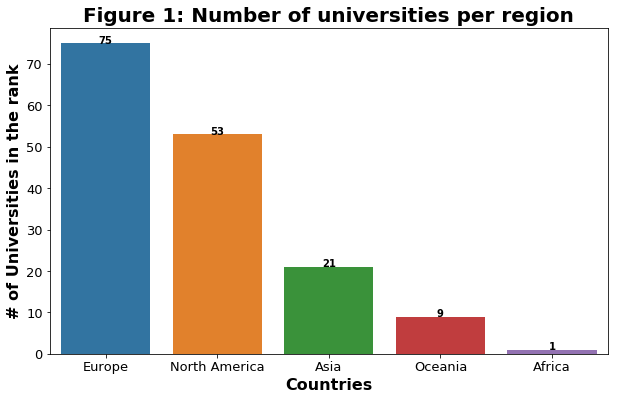

In [37]:
# Visualize how many universitie sper country are there in the best 200 ranking
plt.figure(figsize=(10,6))
regions = merged_df_avg.region.value_counts().index
ax = sns.barplot(x=regions, y=merged_df_avg.region.value_counts())
value_barplot_label(ax)
plt.title("Figure 1: Number of universities per region", fontsize=20).set_weight('bold')
tick_format(ax, 3)
ax.set_ylabel('# of Universities in the rank', fontsize=16).set_weight('bold')
ax.set_xlabel('Countries', fontsize=16).set_weight('bold')

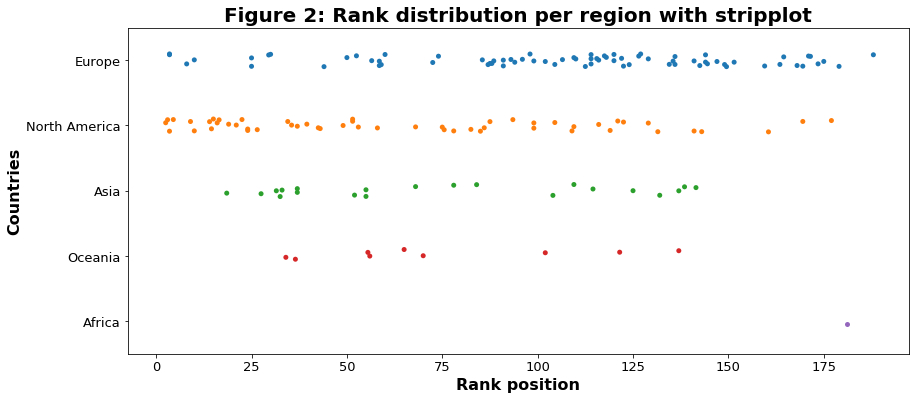

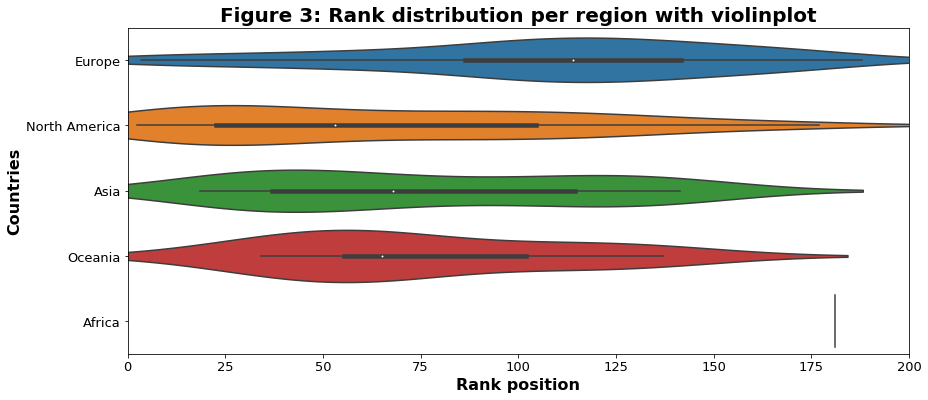

In [38]:
# Rank distribution per region
# Stripplot
plt.figure(figsize=(14,6))
ax = sns.stripplot(x="AVG_rank", y="region", data=merged_df_avg, jitter=True, order=merged_df_avg.region.value_counts().index)
plt.title("Figure 2: Rank distribution per region with stripplot", fontsize=20).set_weight('bold')
tick_format(ax, 3)
ax.set_ylabel('Countries', fontsize=16).set_weight('bold')
ax.set_xlabel('Rank position', fontsize=16).set_weight('bold')

# Violin plot
plt.figure(figsize=(14,6))
ax = sns.violinplot(x="AVG_rank", y="region", data=merged_df_avg, order=merged_df_avg.region.value_counts().index)
plt.xlim(0,200)
plt.title("Figure 3: Rank distribution per region with violinplot", fontsize=20).set_weight('bold')
tick_format(ax, 3)
ax.set_ylabel('Countries', fontsize=16).set_weight('bold')
ax.set_xlabel('Rank position', fontsize=16).set_weight('bold')

- From Figure 1, Europe and North America are the regions where there are the best universities. 

- In Figure 2 and 3 we can observe the different distributions in the rank for each region. **Europe is the region which has more universities in the ranking**, however **North America obtains a better median rank position** result (120 vs 70). 

- In addition, it can be observed that **Asia and Oceania** don't have a lot universities in the ranking, however there **are well placed**.

Let's step down one level: For each region, the different countries that have universities in the rank will be analysed.

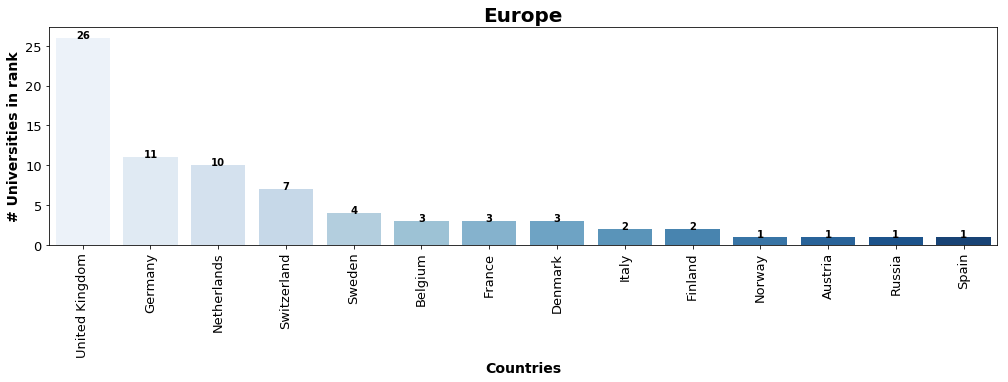

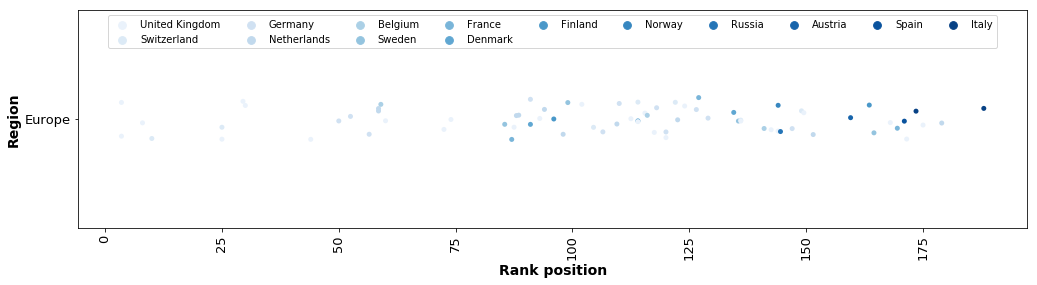

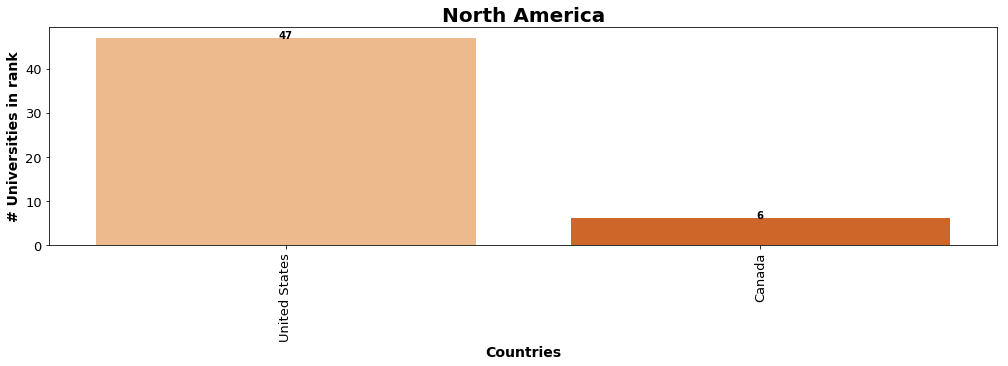

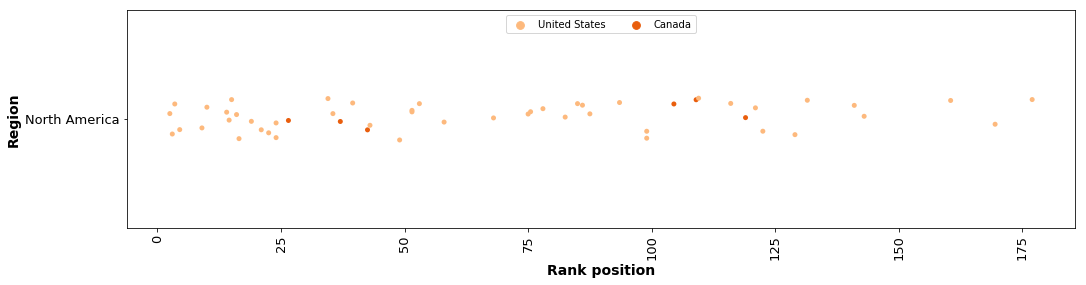

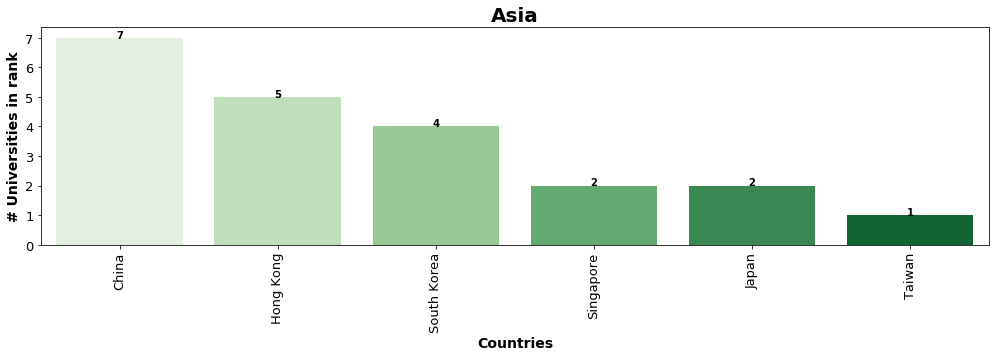

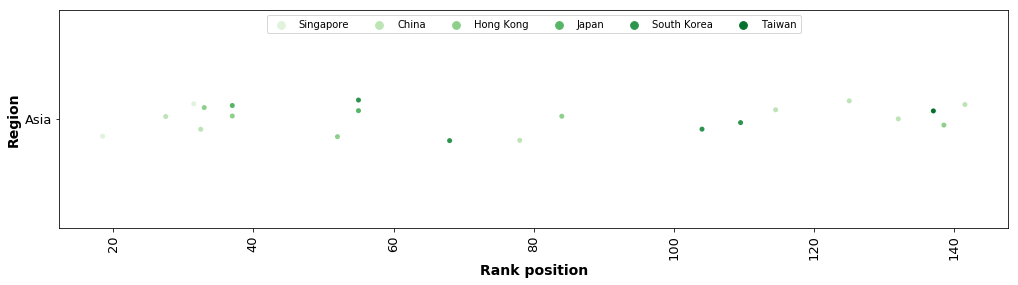

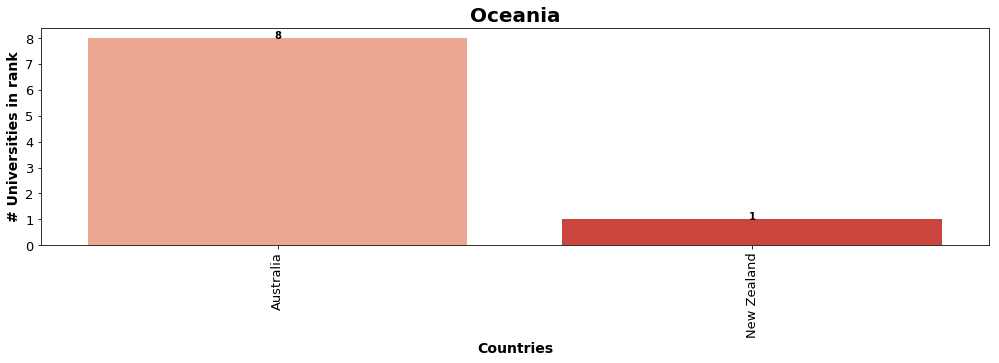

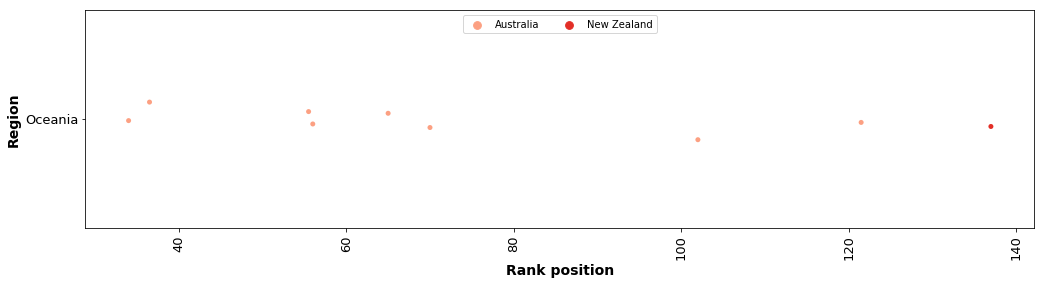

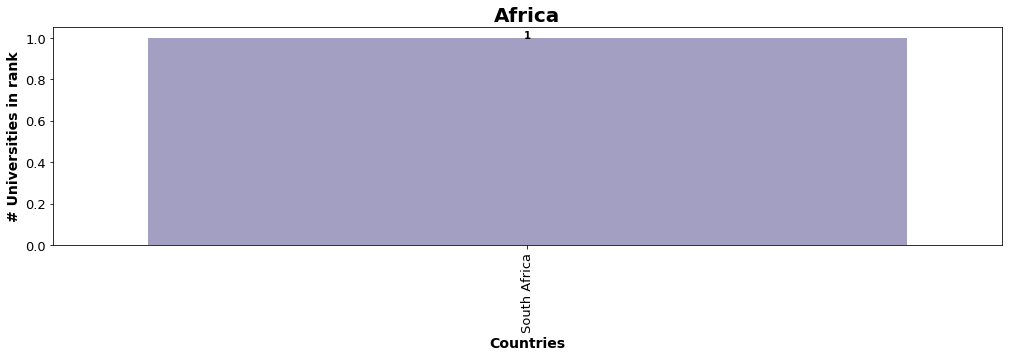

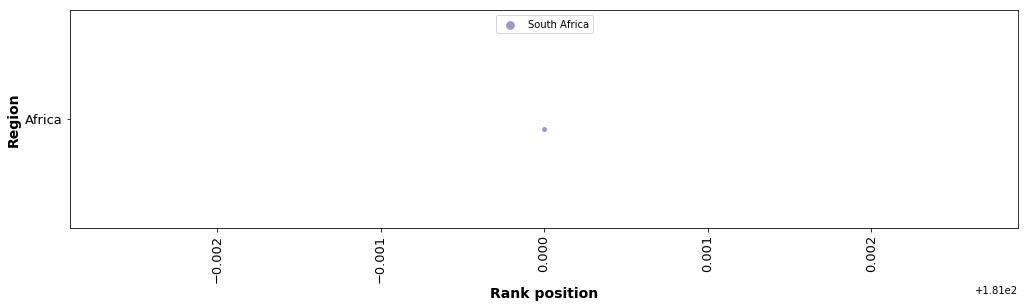

In [39]:
# Best 5 universities in Europe   
colors = ['Blues','Oranges', 'Greens', 'Reds','Purples']
for region, color in zip(regions, colors):
    plt.figure(figsize=(17,4))
    x = merged_df_avg.country[merged_df_avg.region==region].value_counts().index
    y = merged_df_avg.country[merged_df_avg.region==region].value_counts()
    ax= sns.barplot(x=x, y=y, palette=color)
    value_barplot_label(ax)
    plt.title(region, fontsize=20).set_weight('bold')
    tick_format(ax,4)
    ax.set_ylabel('# Universities in rank', fontsize=14).set_weight('bold')
    ax.set_xlabel('Countries', fontsize=14).set_weight('bold')
    
    plt.figure(figsize=(17,4))
    ax = sns.stripplot(x="AVG_rank", y="region", data=merged_df_avg[merged_df_avg.region==region], jitter=True, hue="country", palette=color)
    plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1), ncol=10, fancybox=True)
    tick_format(ax,4)
    ax.set_ylabel('Region', fontsize=14).set_weight('bold')
    ax.set_xlabel('Rank position', fontsize=14).set_weight('bold')

- ***Europe***:
    * The three countries with more universities in the rank are: United Kingdom, Germany and Netherlands.
    * However, the **best universities in Europe** are from United Kingdom and **Switzerland**.
    * It can be observed that having **more universities in the rank** per country, means that it is **more probable to have a well placed** universities (the darker colors are at the end of the second plot).
    
    
- ***North America***:
    * The United States has 46 ranked universities vs 7 in Canada.
    * It can be observed that a considerable amount of universities in the **United States** are very well ranked (**13 within the top 25**).
    
    
- ***Asia***:
    * The three countries with more universities in the rank are: Japan, South Korea and China.
    * Singapore has only 2 universities in the rank (as it is a small country), however has the two best universities of Asia. It is a similar case as Switzerland.
    
    
- ***Oceania***:
    * Australia has 9 ranked universities vs 2 in New Zeland.
  
  
- ***Latin America***:
    * The number of universities well ranked are very similar within the countries in Latin America.
    * The **best university** in Latin America is in **Argentina**.

Now, we want compute the relative ratio of number of universities and population per country. Let's define this ration:


\begin{equation}
\text{size_rel_ratio} = \frac{\text{Number of ranked Universities in the country}}{\text{Population}}
\end{equation}



First a new dataset which provides us with this information is found: The dataset by countries has been downloaded from https://www.imf.org/external/pubs/ft/weo/2017/01/weodata/download.aspx


A helper function has been built in order to extract the interesting data from this dataset


#### Helper Functions

In [40]:
# Helper functions
def get_info(data, countries_list_,country_population, subj_descript):
    
    # Obtain the interesting columns and set the country as index of the dataframe
    df = data[data['Subject Descriptor'] == subj_descript]
    df = df.drop(['Subject Descriptor','Scale', 'Units'],axis=1)
    df.set_index('Country', inplace=True)
    
    # Dataframe cleaning
    columns = [2017, 2022]  # Actual data and prediction of 2022
    for column in columns:
        df[column] = df[column].replace({r'n/a': ''},regex=True).replace({r',': ''}, regex=True)
    df = df.loc[countries_list_]
    df.fillna(value=-99,axis=1, inplace=True)
    
    for column in columns:
        df[column] = df[column].apply(pd.to_numeric).astype(int)
    
    return df

In the following cell, we are simply extracting the population number from the dataset, and merging this information with the number of universities per countries dataframe. In this way, the size relative value can be obtained.

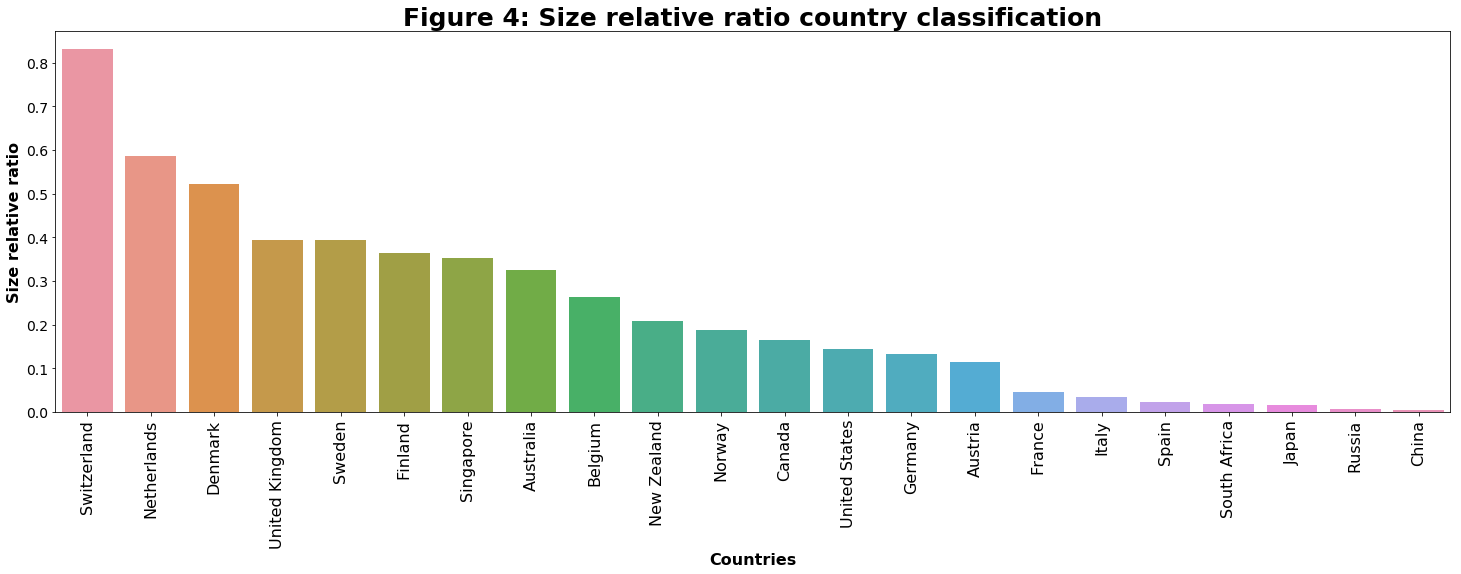

In [41]:
# Load the data from this new dataset
data = pd.read_excel('WEOApr2017all.xls')
data = data[['Country', 'Subject Descriptor', 'Scale', 'Units', 2017, 2022]]

# Countries list of the main dataset
countries_list_ = merged_df_avg.country.value_counts().index

# Get the information from the dataset.
country_population = pd.DataFrame()
country_population = get_info(data, countries_list_, country_population, 'Population')

# Rename columns and drop the 2022 column
del country_population[2022]
country_population.rename(columns={2017: 'population_2017'}, inplace=True)

# Create dataframe with number of universities per country
uni_per_country = merged_df_avg.country.value_counts().get_values()
country_names = merged_df_avg.country.value_counts().index
d = {'country': country_names, 'uni_per_country': uni_per_country}
uni_per_country = pd.DataFrame(data=d)

# Change th units od China and India as they are in Millions 
country_population.population_2017.loc['China'] = country_population.population_2017.loc['China'] * 1000

# Set country as a column in population df
country_population_res = country_population.reset_index()
country_population_res.rename(columns={'index': 'country'}, inplace=True)

# Merge this information to a unique df
new_merged = pd.merge(uni_per_country, country_population_res, how='left', on='country')
new_merged.population_2017 = new_merged.population_2017/1000  # Set the units of population in millions of inhabitants
new_merged = new_merged[new_merged.population_2017 > 0]

# Compute the size relative ratio
new_merged['size_rel_ratio'] = new_merged.uni_per_country / new_merged.population_2017
new_merged = new_merged.sort_values('size_rel_ratio', ascending=False)
new_merged_plot = new_merged.head(23)
new_merged_plot = new_merged_plot.drop(new_merged_plot[['uni_per_country','population_2017']], axis=1)

# Visualize how many universitie sper country are there in the best 200 ranking
plt.figure(figsize=(25,7))
ax = sns.barplot(x=new_merged_plot.country, y=new_merged_plot.size_rel_ratio)
plt.title("Figure 4: Size relative ratio country classification", fontsize=25).set_weight('bold')
tick_format(ax, 1)
ax.set_ylabel('Size relative ratio', fontsize=16).set_weight('bold')
ax.set_xlabel('Countries', fontsize=16).set_weight('bold')

The conclusions that can be drown from Figure 4 are that **Switzerland, Neatherlands, Denmark** have the **highest size relative ratio**, which means that they have a lot of universities in the ranking relatively to his population size.

In addition, we can observe that most of the universities are European universities.

## 5.2) The relation of the internationality of the university and the rank position

The main goal of this section is to analyse the effect of the internationality of the university to the rank placement. 

Let's first visualize the boxplot of the internation student ratio and the faculty members ratio of the 200 best universities:

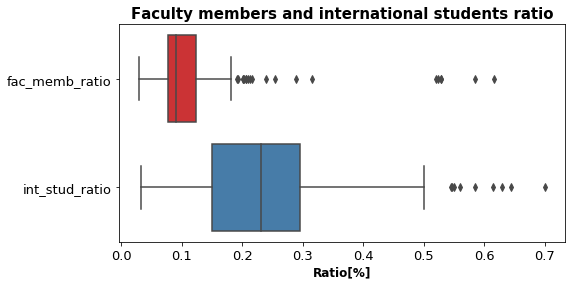

In [42]:
# Visualize the ratios with a boxplot
plt.figure(figsize=(8,4))
ax1 = sns.boxplot(data=merged_df_avg[['fac_memb_ratio', 'int_stud_ratio']], orient="h", palette="Set1")
plt.title("Faculty members and international students ratio", fontsize=15).set_weight('bold')
tick_format(ax1, 3)
ax1.set_xlabel('Ratio[%]', fontsize=12).set_weight('bold')

It can be observed that:

    - The median of faculty members ratio of the best universities is 9%
    
    - The median of international students ratio is 22%
    
    - There is a university that has a ratio around 70%
    
    
Let's research then which are the universities with higher international student ratio.    

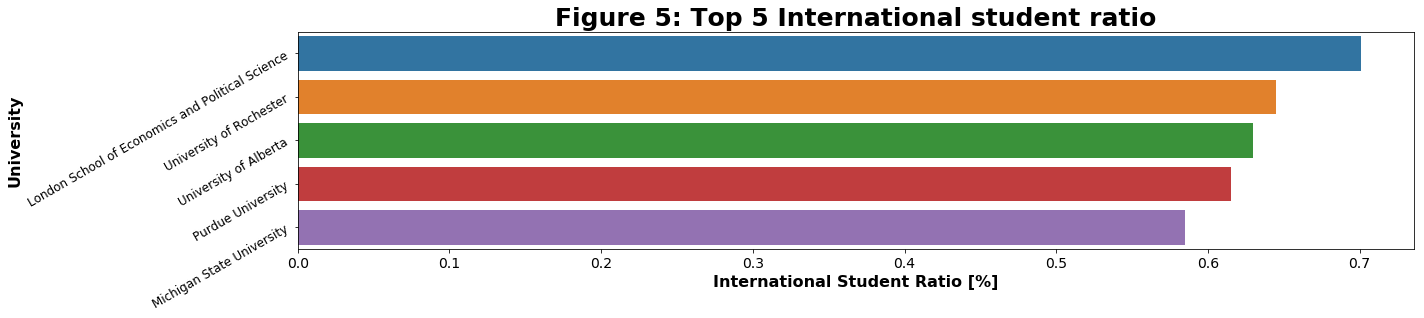

In [43]:
int_uni = merged_df_avg.sort_values('int_stud_ratio', ascending=False)
int_uni_plot = int_uni.head(5)

# Visualize how many universitie sper country are there in the best 200 ranking
plt.figure(figsize=(20,4))
ax = sns.barplot(x=int_uni_plot.int_stud_ratio, y=int_uni_plot.University )
plt.title("Figure 5: Top 5 International student ratio", fontsize=25).set_weight('bold')
tick_format(ax, 5)
ax.set_ylabel('University', fontsize=16).set_weight('bold')
ax.set_xlabel('International Student Ratio [%]', fontsize=16).set_weight('bold')

From Figure 5, it can be seen that **EPFL is the third universitiy with highest international ratio**.


The correlation of the rank position with the internationality of the university will be now analysed

In [44]:
# Describe the data
merged_df_avg.describe()

,THE_rank,QS_rank,AVG_rank,nb_stud_tot,int_stud_ratio,fac_memb_int,fac_memb_tot,nb_stud_int,fac_memb_ratio,Score citations
count,159.000000,159.000000,159.000000,159.000000,159.000000,159.000000,159.000000,159.000000,159.000000,159.000000
mean,87.283019,88.735849,88.009434,24763.597484,0.244049,847.408805,2344.113208,5319.814465,0.122219,72.883019
std,54.364700,55.586454,50.019252,12629.948887,0.132100,690.141173,1301.165302,3317.879147,0.098250,20.851912
min,1.000000,1.000000,2.500000,523.500000,0.032091,-99.000000,88.500000,42.000000,0.029661,-19.400000
25%,42.500000,40.500000,43.500000,15841.750000,0.150023,379.000000,1280.000000,3193.000000,0.077739,64.475000
50%,83.000000,84.000000,91.000000,23602.000000,0.231104,661.000000,2189.500000,4619.500000,0.091169,74.700000
75%,131.000000,134.500000,125.750000,31651.500000,0.295816,1104.500000,3018.500000,7027.750000,0.122871,85.475000
max,198.000000,200.000000,188.000000,70817.000000,0.700697,3905.000000,7448.000000,17438.000000,0.616279,99.950000


From the statistical description of the different variables, it can be drown:
    
    * The mean of total number students is 25'358 and the mean is at 523. EPFL is below the 25% quartile of all universities in the rank.
    
    * The mean international students ratio is 23% and the maximal is at 70%
    
    * The mean of faculty members ratio is at 11% and the maximal is at 55%.

In [ ]:
# Compute the correlation matrix
corr = merged_df_avg.corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=1, cbar_kws={"shrink": .5})

plt.title("Features correlation Heat Map", fontsize=20).set_weight('bold')

From this heat map, it can be concluded that the internationality of a university is strongly negative correlated with the rank they have in both rankings. In other words, if a university wants to be higher in the rankings, it should be more international. The same for the faculty members ratio. By having a higher ratio means that there is more probability to be on the top of the rank.

In addition, the fact that having higher number of international students, is more strongly negative correlated in the QS_rank than in the THE_rank. t

## 5.3) Is there a relation of "predicted growth of GDP 2017-2022" and "number of university per nation in the rankings"?

To answer this question, we are going to use the GDP data for each country of the dataset used before. Then, this data will be merged with the number of universities per country dataframe. Finally the correlation between this two variable will be computed.

In [ ]:
country_gdp = pd.DataFrame()
country_gdp = get_info(data, countries_list_, country_gdp, \
                       'Gross domestic product based on purchasing-power-parity (PPP) per capita GDP')

country_gdp.rename(columns={2017: 'gdp_2017', 2022: 'gdp_2022' }, inplace=True)
country_gdp['gdp_pred_inc'] = (country_gdp.gdp_2022.astype(float) - country_gdp.gdp_2017.astype(float))\
                                        /country_gdp.gdp_2017.astype(float)
country_gdp =  country_gdp[country_gdp.gdp_pred_inc > 0]   
country_gdp.gdp_pred_inc = (country_gdp.gdp_pred_inc - country_gdp.gdp_pred_inc.mean())\
                            / (country_gdp.gdp_pred_inc.max() - country_gdp.gdp_pred_inc.min())

del country_gdp['gdp_2017']
del country_gdp['gdp_2022']

# Set country as a column in population df
country_gdp_res = country_gdp.reset_index()
country_gdp_res.rename(columns={'index': 'country'}, inplace=True)

# Merge this information to a unique df
new_merged_gdp = pd.merge(uni_per_country, country_gdp_res, how='left', on='country')
new_merged_gdp.corr()

From the correlation matrix displayed above, it can be concluded that there is a **negligible correlation** between the **number of universities per ranking** and the **predicted increase of richness** of the country. 

# 6) Best university taking in consideration both rankings

After obtaining the merged dataset with the combination of both rankings, we are able to create our own ranking.


The criteria used is the following: The three main poles to consider a university a good university are the score citations (**quality of its research**), the faculty members to student ratio (**quality of teaching**) and international student ratio (**international appeal of the university**). An equal linear combination of these three indicators has been considered between this three factors.

In [ ]:
# Create the university scoring value
alpha=1
beta=1
gamma=1

MyScore =  alpha*merged_df_avg['Score citations']/100 \
                    + beta*merged_df_avg['fac_memb_ratio'] \
                        + gamma*merged_df_avg['int_stud_ratio']

In [ ]:
# Observe the statistical description of the scoring
MyScore.describe()

It can be seen that it is found a very well distributed score. So it can be assumed that this is a good metric.

In [ ]:
# SHow the top 10 of the new ranking
merged_df_avg['MyScore'] = MyScore
merged_df_avg = merged_df_avg.sort_values('MyScore',ascending=False).head(10)

In [ ]:
# Visualize TOP10
plt.figure(figsize=(15,10))
ax = sns.barplot(x=merged_df_avg.MyScore.head(10), y=merged_df_avg.University.head(10))
plt.title("TOP10 Universities with MyScore", fontsize=25).set_weight('bold')
tick_format(ax, 1)
ax.set_ylabel('University', fontsize=20).set_weight('bold')
ax.set_xlabel('My Score', fontsize=16).set_weight('bold')

In [ ]:
BEST_FUCKING_UNI_IN_THE_WORLD = merged_df_avg.loc[merged_df_avg['MyScore']==merged_df_avg['MyScore'].max()]

In [ ]:
BEST_FUCKING_UNI_IN_THE_WORLD